## Install modules and packages

In [537]:
%%capture
%pip install numpy pandas seaborn matplotlib scikit-learn imbalanced-learn xgboost

In [538]:
# Basic EDA and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Imputations and utils
from sklearn.impute import KNNImputer
from sklearn.utils import resample

# Metrics and calculations
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Ensemble models
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

## EDA

In [539]:
# Helper functions

def corr_matrix(dataframe):
    plt.figure(figsize=(10, 8))
    sns.heatmap(dataframe.corr(numeric_only=True), annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()
    
def histogram(df, avoid, name_for_title='Train'):
    df_copy = df.copy(deep=True)
    df_copy.drop(labels=avoid, axis='columns',inplace=True)

    fig, axes = plt.subplots(3, 3, constrained_layout=True, figsize=(10, 8))
       
    plt.suptitle('Distribution of Features in ' + name_for_title + ' Set', fontsize=20)
    
    r = 0
    c = 0
    
    for col in df_copy.columns:
        sns.histplot(data=df, x=col, kde=True, ax=axes[r, c])
        axes[r, c].title.set_text('Histogram of ' + str(col))
        if (c == 2):
            c = 0
            r += 1
        else: 
            c += 1
            
    fig.delaxes(axes[2, 2])

In [540]:
train = pd.read_csv("datasets//sepsis-dataset//train.csv")
test = pd.read_csv("datasets//sepsis-dataset//test.csv")

In [541]:
print(train.shape)
print(test.shape)

(599, 11)
(169, 10)


In [542]:
train.head(5)

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive


In [543]:
train = train.drop_duplicates()
test = test.drop_duplicates()

train.drop(columns=["ID", "Insurance"], inplace=True)
test.drop(columns=["ID", "Insurance"], inplace=True)

In [544]:
train.rename(columns={"Sepssis": "Sepsis"}, inplace=True)

train['Sepsis'] = train['Sepsis'].map({'Positive': 1, 'Negative': 0}).astype('int')

In [545]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PRG     599 non-null    int64  
 1   PL      599 non-null    int64  
 2   PR      599 non-null    int64  
 3   SK      599 non-null    int64  
 4   TS      599 non-null    int64  
 5   M11     599 non-null    float64
 6   BD2     599 non-null    float64
 7   Age     599 non-null    int64  
 8   Sepsis  599 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 42.2 KB


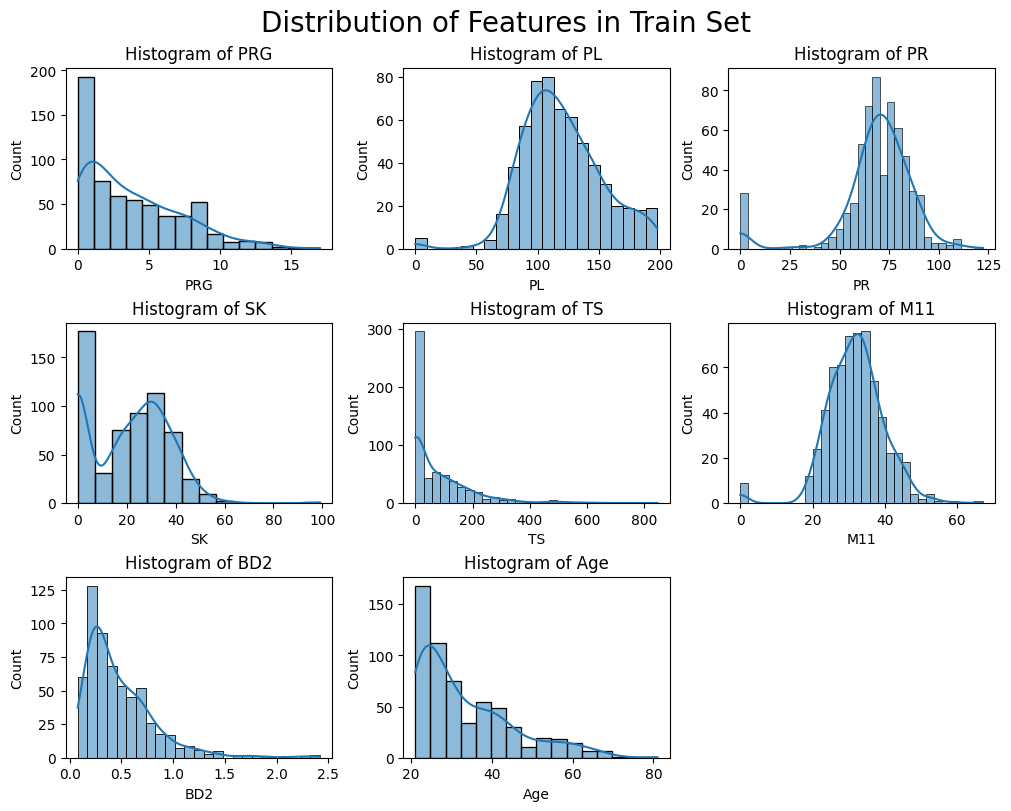

In [546]:
histogram(train, avoid=['Sepsis'])

In [547]:
train

,PRG,PL,PR,SK,TS,M11,BD2,Age,Sepsis
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
594,6,123,72,45,230,33.6,0.733,34,0
595,0,188,82,14,185,32.0,0.682,22,1
596,0,67,76,0,0,45.3,0.194,46,0
597,1,89,24,19,25,27.8,0.559,21,0


In [548]:
columns_to_impute = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11']
train[columns_to_impute] = train[columns_to_impute].replace(0, np.nan)

In [552]:
imputer = KNNImputer(n_neighbors=5)

imputed_train = imputer.fit_transform(train)

train = pd.DataFrame(imputed_train, columns=train.columns)

In [553]:
train

,PRG,PL,PR,SK,TS,M11,BD2,Age,Sepsis
0,6.0,148.0,72.0,35.0,281.6,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.0,58.6,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,25.8,164.6,23.3,0.672,32.0,1.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0
4,6.6,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1.0
...,...,...,...,...,...,...,...,...,...
594,6.0,123.0,72.0,45.0,230.0,33.6,0.733,34.0,0.0
595,6.4,188.0,82.0,14.0,185.0,32.0,0.682,22.0,1.0
596,5.6,67.0,76.0,36.2,52.8,45.3,0.194,46.0,0.0
597,1.0,89.0,24.0,19.0,25.0,27.8,0.559,21.0,0.0


In [554]:
test[columns_to_impute] = test[columns_to_impute].replace(0, np.nan)

In [555]:
imputer = KNNImputer(n_neighbors=5)

imputed_test = imputer.fit_transform(test)

test = pd.DataFrame(imputed_test, columns=test.columns)

In [556]:
test

,PRG,PL,PR,SK,TS,M11,BD2,Age
0,1.0,109.0,38.0,18.0,120.0,23.1,0.407,26.0
1,1.0,108.0,88.0,19.0,99.4,27.1,0.400,24.0
2,6.0,96.0,67.4,19.2,120.8,23.7,0.190,28.0
3,1.0,124.0,74.0,36.0,133.6,27.8,0.100,30.0
4,7.0,150.0,78.0,29.0,126.0,35.2,0.692,54.0
...,...,...,...,...,...,...,...,...
164,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63.0
165,2.0,122.0,70.0,27.0,157.2,36.8,0.340,27.0
166,5.0,121.0,72.0,23.0,112.0,26.2,0.245,30.0
167,1.0,126.0,60.0,36.4,101.8,30.1,0.349,47.0


In [558]:
for column in ['TS', 'BD2', 'SK', 'Age', 'PRG', 'M11', 'PL', 'PR']:
    train[column] = np.log1p(train[column])

In [557]:
for column in ['TS', 'BD2', 'SK', 'Age', 'PRG', 'M11', 'PL', 'PR']:
    test[column] = np.log1p(test[column])

In [559]:
train['TS'] = np.where(train['TS'] > train['TS'].quantile(0.75),
                       train['TS'].quantile(0.75), train['TS'])
train['PRG'] = np.where(train['PRG'] > train['PRG'].quantile(0.75),
                        train['PRG'].quantile(0.75), train['PRG'])
train['Age'] = np.where(train['Age'] > train['Age'].quantile(0.75),
                        train['Age'].quantile(0.75), train['Age'])

In [560]:
test['TS'] = np.where(test['TS'] > test['TS'].quantile(0.75),
                       test['TS'].quantile(0.75), test['TS'])
test['PRG'] = np.where(test['PRG'] > test['PRG'].quantile(0.75),
                        test['PRG'].quantile(0.75), test['PRG'])
test['Age'] = np.where(test['Age'] > test['Age'].quantile(0.75),
                        test['Age'].quantile(0.75), test['Age'])

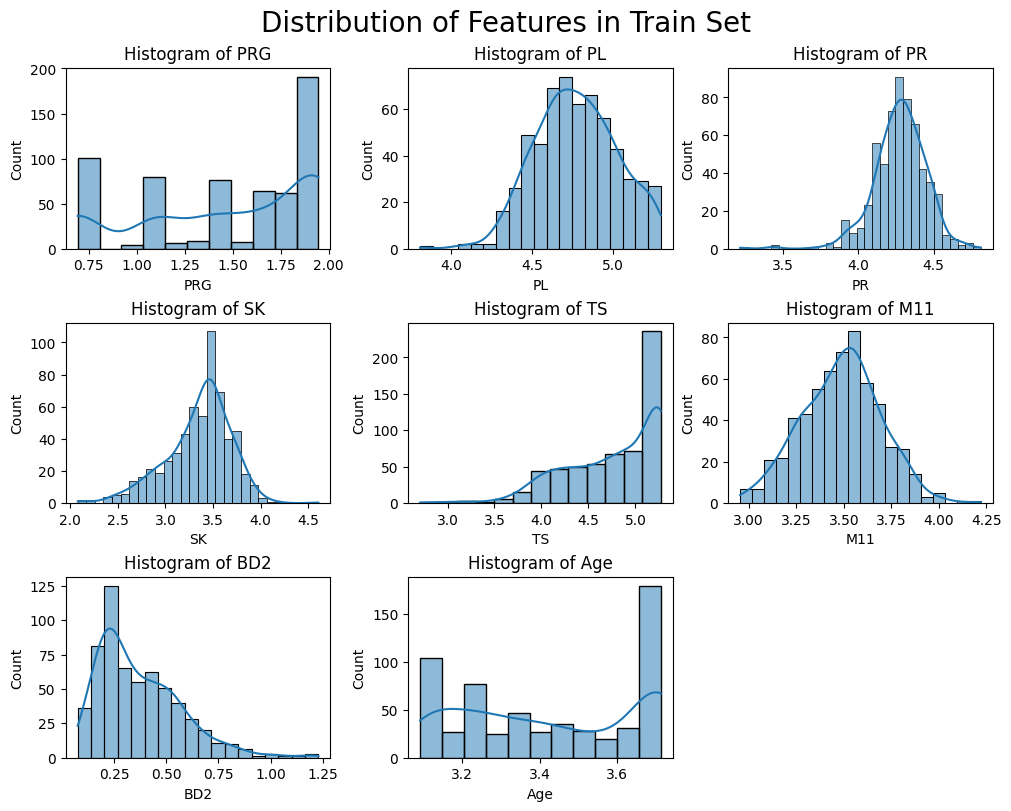

In [561]:
histogram(train, avoid=['Sepsis'])

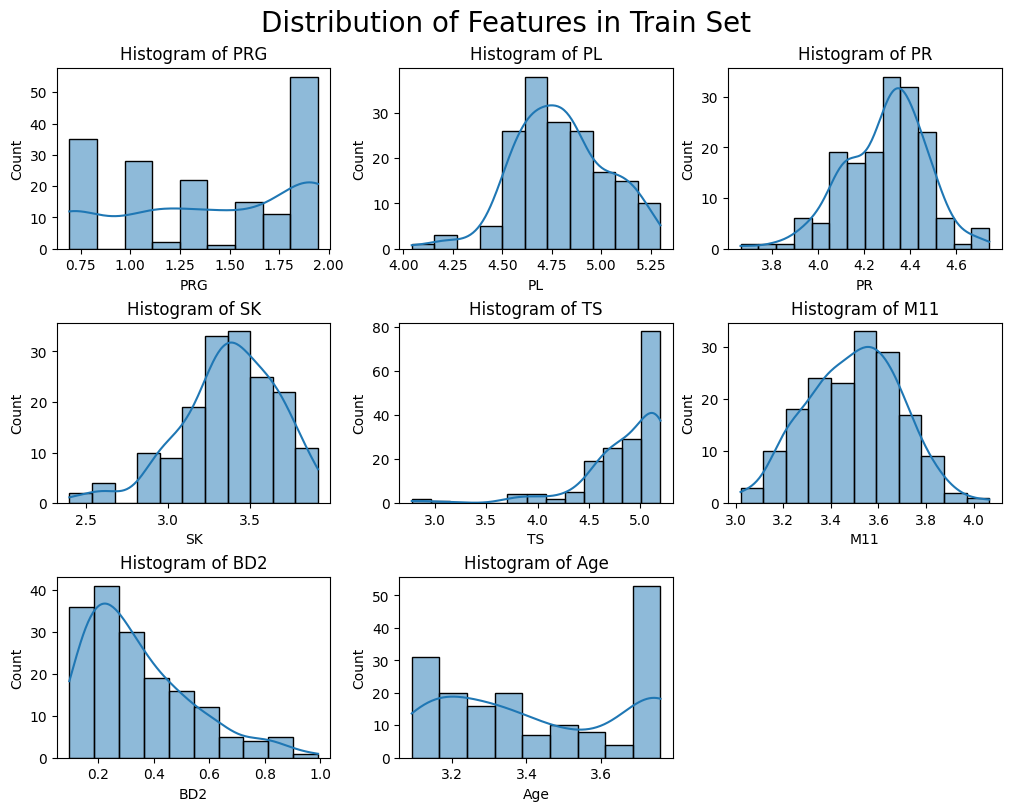

In [563]:
histogram(test, avoid=[])

In [566]:
train['Sepsis'].value_counts()

Sepsis
0.0    391
1.0    208
Name: count, dtype: int64

In [567]:
train['Sepsis'] = train['Sepsis'].astype('int')

In [568]:
train_majority = train[train['Sepsis'] == 0]
train_minority = train[train['Sepsis'] == 1]

sepsis_train_df_minority_upsampled = resample(train_minority,
                                              replace=True,
                                              n_samples=391,
                                              random_state=123)

train = pd.concat([train_majority, sepsis_train_df_minority_upsampled])

In [569]:
train['Sepsis'].value_counts()

Sepsis
0    391
1    391
Name: count, dtype: int64

In [570]:
train.reset_index(inplace=True, drop=True)

In [571]:
train

,PRG,PL,PR,SK,TS,M11,BD2,Age,Sepsis
0,0.693147,4.454347,4.204693,3.401197,4.087656,3.317816,0.300845,3.465736,0
1,0.693147,4.499810,4.204693,3.178054,4.553877,3.370738,0.154436,3.091042,0
2,1.791759,4.762174,4.317488,2.944439,4.572647,3.280911,0.183155,3.433987,0
3,1.945910,4.753590,4.312141,3.514526,4.852030,3.591818,0.125751,3.401197,0
4,1.609438,4.709530,4.532599,3.310543,5.029130,3.653252,0.174793,3.433987,0
...,...,...,...,...,...,...,...,...,...
777,1.945910,5.030438,4.510860,3.526361,3.401197,3.325036,0.548699,3.713572,1
778,1.945910,5.030438,4.510860,3.526361,3.401197,3.325036,0.548699,3.713572,1
779,1.945910,5.220356,4.442651,3.526361,5.241747,3.597312,0.303801,3.713572,1
780,1.945910,4.787492,3.931826,3.135494,5.176150,3.335770,0.840705,3.526361,1


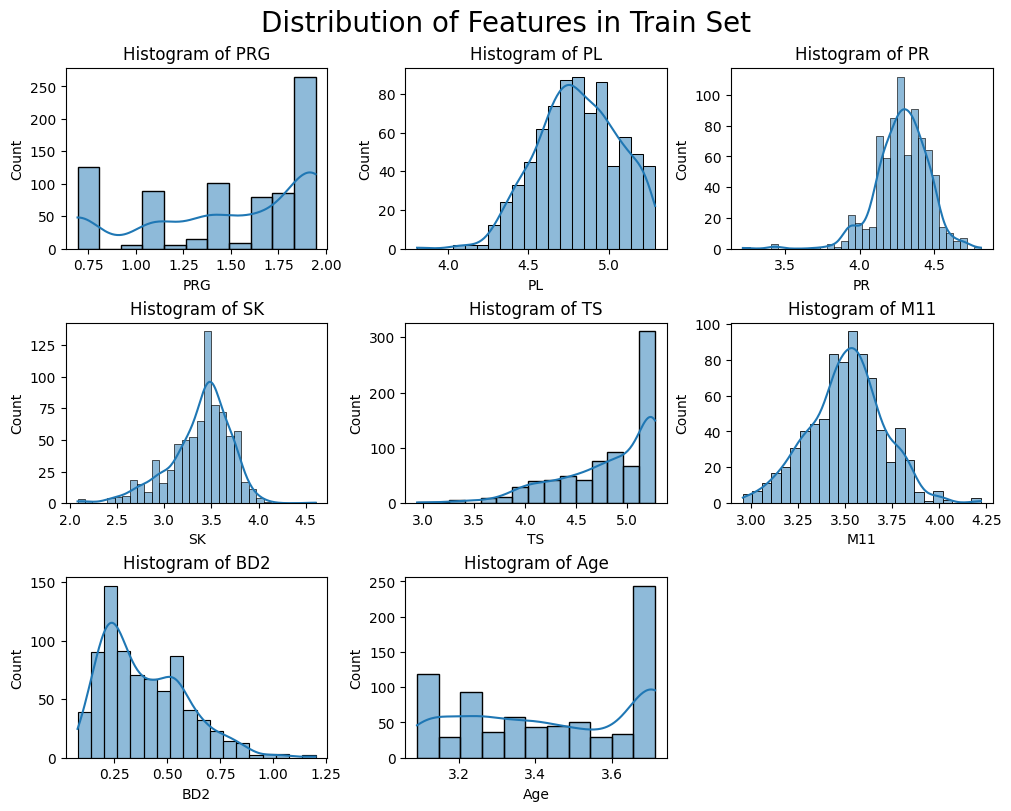

In [572]:
histogram(train, avoid=['Sepsis'])

In [573]:
train.to_csv("train_cleaned.csv", index=False)

# Training

In [574]:
X = train.drop('Sepsis', axis=1)
y = train['Sepsis']

In [575]:
X

,PRG,PL,PR,SK,TS,M11,BD2,Age
0,0.693147,4.454347,4.204693,3.401197,4.087656,3.317816,0.300845,3.465736
1,0.693147,4.499810,4.204693,3.178054,4.553877,3.370738,0.154436,3.091042
2,1.791759,4.762174,4.317488,2.944439,4.572647,3.280911,0.183155,3.433987
3,1.945910,4.753590,4.312141,3.514526,4.852030,3.591818,0.125751,3.401197
4,1.609438,4.709530,4.532599,3.310543,5.029130,3.653252,0.174793,3.433987
...,...,...,...,...,...,...,...,...
777,1.945910,5.030438,4.510860,3.526361,3.401197,3.325036,0.548699,3.713572
778,1.945910,5.030438,4.510860,3.526361,3.401197,3.325036,0.548699,3.713572
779,1.945910,5.220356,4.442651,3.526361,5.241747,3.597312,0.303801,3.713572
780,1.945910,4.787492,3.931826,3.135494,5.176150,3.335770,0.840705,3.526361


In [576]:
y

0      0
1      0
2      0
3      0
4      0
      ..
777    1
778    1
779    1
780    1
781    1
Name: Sepsis, Length: 782, dtype: int64

In [577]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state=42)

print("Shape of X_train: " + str(X_train.shape))
print("Shape of X_test: " + str(X_test.shape))

Shape of X_train: (625, 8)
Shape of X_test: (157, 8)


In [578]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000000000),
    'SGD Classifier': SGDClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'GaussianNB': GaussianNB(),
    'KNeighbors': KNeighborsClassifier(),
    'Neural Network': MLPClassifier(max_iter=10000000),
    'XGB': XGBClassifier()
}
models

{'Logistic Regression': LogisticRegression(max_iter=10000000000),
 'SGD Classifier': SGDClassifier(),
 'Random Forest': RandomForestClassifier(),
 'Gradient Boosting': GradientBoostingClassifier(),
 'GaussianNB': GaussianNB(),
 'KNeighbors': KNeighborsClassifier(),
 'Neural Network': MLPClassifier(max_iter=10000000),
 'XGB': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, 

In [579]:
model_names = []
model_average_scores = []
for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train)
    model_names.append(model_name)
    model_average_scores.append(scores.mean())

In [580]:
models_data = pd.DataFrame()
models_data['Model'] = model_names
models_data['Avg Score'] = model_average_scores
models_data

,Model,Avg Score
0,Logistic Regression,0.7408
1,SGD Classifier,0.6944
2,Random Forest,0.8544
3,Gradient Boosting,0.8416
4,GaussianNB,0.7504
5,KNeighbors,0.7424
6,Neural Network,0.6720
7,XGB,0.8496


In [581]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid_LR = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs', 'newton-cg'],
}

param_grid_SGD = {
    'loss': ['hinge', 'log_loss', 'squared_hinge'],
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [1000, 2000, 3000],
}

param_grid_RF = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

param_grid_GBC = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}

param_grid_GNB = {}

param_grid_MNB = {}

param_grid_KNN = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
}

param_grid_MLP = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],
}

param_grid_XGB = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
}

In [582]:
models = {
    'Logistic Regression': (LogisticRegression(max_iter=100000), param_grid_LR),
    'SGD Classifier': (SGDClassifier(), param_grid_SGD),
    'Random Forest': (RandomForestClassifier(), param_grid_RF),
    'Gradient Boosting': (GradientBoostingClassifier(), param_grid_GBC),
    'GaussianNB': (GaussianNB(), param_grid_GNB),
    'KNeighbors': (KNeighborsClassifier(), param_grid_KNN),
    'Neural Network': (MLPClassifier(max_iter=10000), param_grid_MLP),
    'XGB': (XGBClassifier(), param_grid_XGB),
}

best_models = {}

for model_name, (model, param_grid) in models.items():
    print(f"Tuning {model_name}...")
    
    optimizer = RandomizedSearchCV(model, param_grid, n_iter=50, scoring='accuracy', n_jobs=-1, cv=cv, random_state=42)
    optimizer.fit(X_train, y_train)
    
    best_models[model_name] = optimizer.best_estimator_
    print(f"Best Parameters for {model_name}: {optimizer.best_params_}")


Tuning Logistic Regression...


d:\VS_CODE\Python-Testing\test\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 18 is smaller than n_iter=50. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for Logistic Regression: {'solver': 'liblinear', 'C': 100}
Tuning SGD Classifier...


d:\VS_CODE\Python-Testing\test\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for SGD Classifier: {'max_iter': 2000, 'loss': 'squared_hinge', 'alpha': 0.001}
Tuning Random Forest...
Best Parameters for Random Forest: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30}
Tuning Gradient Boosting...


d:\VS_CODE\Python-Testing\test\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 18 is smaller than n_iter=50. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for Gradient Boosting: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1}
Tuning GaussianNB...
Best Parameters for GaussianNB: {}
Tuning KNeighbors...


d:\VS_CODE\Python-Testing\test\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
d:\VS_CODE\Python-Testing\test\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 8 is smaller than n_iter=50. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for KNeighbors: {'weights': 'distance', 'n_neighbors': 3}
Tuning Neural Network...


d:\VS_CODE\Python-Testing\test\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for Neural Network: {'hidden_layer_sizes': (50, 50), 'alpha': 0.001, 'activation': 'tanh'}
Tuning XGB...
Best Parameters for XGB: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1}


In [ ]:
best_models

In [583]:
results = []

for model_name, model in best_models.items():
    print(f"Evaluating {model_name}...")
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    results.append((model_name, accuracy))

results_df = pd.DataFrame(results, columns=['Model', 'Accuracy'])

results_df = results_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

Evaluating Logistic Regression...
Evaluating SGD Classifier...
Evaluating Random Forest...
Evaluating Gradient Boosting...
Evaluating GaussianNB...
Evaluating KNeighbors...
Evaluating Neural Network...
Evaluating XGB...


In [584]:
results_df

,Model,Accuracy
0,Gradient Boosting,0.910828
1,Random Forest,0.910828
2,XGB,0.898089
3,KNeighbors,0.828025
4,Logistic Regression,0.802548
5,SGD Classifier,0.770701
6,GaussianNB,0.757962
7,Neural Network,0.751592


In [585]:
voting_clf = VotingClassifier(estimators=[
    ('rf', best_models['Random Forest']),
    ('xgb', best_models['XGB']),
    ('gb', best_models['Gradient Boosting'])
], voting='hard')

voting_clf.fit(X_train, y_train)

y_pred_voting = voting_clf.predict(X_test)
accuracy_voting = accuracy_score(y_test, y_pred_voting)
print(f"Voting Classifier Accuracy: {accuracy_voting}")

Voting Classifier Accuracy: 0.89171974522293


In [586]:
estimators = [
    ('rf', best_models['Random Forest']),
    ('xgb', best_models['XGB']),
    ('gb', best_models['Gradient Boosting'])
]

stacked_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacked_model.fit(X_train, y_train)

y_pred_stacking = stacked_model.predict(X_test)
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
print(f"Stacking Classifier Accuracy: {accuracy_stacking}")

Stacking Classifier Accuracy: 0.910828025477707


## Testing

In [587]:
test

,PRG,PL,PR,SK,TS,M11,BD2,Age
0,0.693147,4.700480,3.663562,2.944439,4.795791,3.182212,0.341460,3.295837
1,0.693147,4.691348,4.488636,2.995732,4.609162,3.335770,0.336472,3.218876
2,1.945910,4.574711,4.225373,3.005683,4.802380,3.206803,0.173953,3.367296
3,0.693147,4.828314,4.317488,3.610918,4.902307,3.360375,0.095310,3.433987
4,1.945910,5.017280,4.369448,3.401197,4.844187,3.589059,0.525911,3.761200
...,...,...,...,...,...,...,...,...
164,1.945910,4.624973,4.343805,3.891820,5.198497,3.523415,0.157858,3.761200
165,1.098612,4.812184,4.262680,3.332205,5.063860,3.632309,0.292670,3.332205
166,1.791759,4.804021,4.290459,3.178054,4.727388,3.303217,0.219136,3.433987
167,0.693147,4.844187,4.110874,3.621671,4.632785,3.437208,0.299364,3.761200


In [589]:
y_pred_voting = voting_clf.predict(test)

y_pred_voting

array([0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0])

In [590]:
y_pred_stacking = stacked_model.predict(test)

y_pred_stacking

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0])